# Tracking Eigenvalues: The Shift-Invert Power Method

### 1. The Strategy
When studying how a Hamiltonian $H(\lambda)$ behaves as we vary a parameter $\lambda$, we don't need to re-diagonalize the whole matrix at every step. Instead, we use a **"tracking" strategy**:

* **The Anchor:** We start with a full diagonalization for an initial $\lambda_0$ to get our baseline energy $E(\lambda_0)$.
* **The Follow-up:** As we shift $\lambda$ slightly, we assume the new energy will be close to the previous one. We use the previous energy as a "guess" or "shift", denoted $\tilde{E}(\lambda)$.

---

### 2. Why Shift-Invert?
The goal is to force the Power Method to ignore the edges of the spectrum and focus exactly on the energy level we are tracking. We do this by applying the iteration to the inverse operator:

$$[H - \tilde{E}(\lambda)I]^{-1} |\psi_n\rangle = \eta |\psi_{n+1}\rangle$$

In this setup, the closer the actual energy $E$ is to our guess $\tilde{E}$, the more the term $1/(E - \tilde{E})$ blows up, making that specific state dominant. This allows the algorithm to converge very quickly to the state we are following.



---

### 3. Avoiding Matrix Inversion
In practice, explicitly calculating the inverse matrix $[H - \tilde{E}I]^{-1}$ is **extremely long and computationally expensive**, especially for large systems. 

To get around this, we treat each step as a linear system to solve:
$$(H - \tilde{E}I) |w\rangle = |\psi_n\rangle$$

We use the **MINRES** algorithm to find $|w\rangle$. It's a clever iterative solver that finds the solution without ever needing to actually invert the matrix, saving a massive amount of time and memory.

---

### 4. Getting the Results Back
Once the iteration settles, we have successfully "captured" the state. We can then easily recover the physical properties of the system:

* **The Eigenvector:** The converged $|\psi\rangle$ is the new state of your Hamiltonian.
* **The Eigenvalue:** We find the energy $E$ simply by calculating the **Rayleigh quotient**:

$$E = \frac{\langle\psi|H|\psi\rangle}{\langle\psi|\psi\rangle}$$

---

To implement it, we will use the following hamiltonian which is the transmon readout one : 
$$\hat{H} = \left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] \otimes \mathbb{I} 
+ \mathbb{I} \otimes \left( \hbar\omega(\hat{a}^\dagger\hat{a}) + \frac{1}{2} \right)
- 4E_{coupling} \hat{n}_T \otimes \left(i n_{ZPF}(\hat{a}^\dagger - \hat{a}) \right)$$

In [106]:
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sp_linalg
from scipy import sparse
from tqdm.notebook import tqdm


### Conversion $C^{n} \to R^{2n}$

As minres only works with real matrixes, we need to add some function to convert our complex operators (if they are) to real ones.

In [71]:
def to_real_basis(H_complex):

    if sp.issparse(H_complex):
        return sp.bmat([
            [H_complex.real, -H_complex.imag],
            [H_complex.imag,  H_complex.real]
        ], format='csr')
    else:
        return np.block([
            [H_complex.real, -H_complex.imag],
            [H_complex.imag,  H_complex.real]
        ])

def vec_to_real(v_complex):
    return np.concatenate((v_complex.real, v_complex.imag))

def vec_to_complex(v_real):
    n = len(v_real) // 2
    return v_real[:n] + 1j * v_real[n:]

def make_real_operator_from_complex(H_complex_op):
    N = H_complex_op.shape[0]
    
    def matvec_real_wrapper(v_real_2n):
        v_c = vec_to_complex(v_real_2n)
        res_c = H_complex_op @ v_c
        return vec_to_real(res_c)

    return sp_linalg.LinearOperator(
        (2*N, 2*N), matvec=matvec_real_wrapper, dtype=np.float64
    )

### Shift invert implementation

In [130]:
# The function to do one calculation step


def callback(xk):
    iterations[-1] += 1

def shift_invert_step(H_op, E_guess, v_prev, shift = 1e-8, tol=1e-8):
    global time_min_res, iterations
    n = H_op.shape[0]
    dtype = H_op.dtype
    v_current = v_prev
    E_current = E_guess
    sigma = E_current + shift
    scale_factor = -1.0 / shift

    is_explicit_matrix = sp.issparse(H_op) or isinstance(H_op, np.ndarray)

    for _ in range(2):
        if is_explicit_matrix:
            iterations.append(0)
            I = sp.eye(n, dtype=dtype, format='csr')
            H_shifted = H_op - sigma * I
            start = time.perf_counter()
            w, exit_code = sp_linalg.minres(H_shifted, v_current, x0=v_current * scale_factor, tol=100*tol, callback = callback)
            end = time.perf_counter()
            time_min_res += (end-start)
        else:
            def shifted_matvec(v):
                return (H_op @ v) - E_current * v
            
            H_shifted = sp_linalg.LinearOperator((n, n), matvec=shifted_matvec, dtype=dtype)
            w, exit_code = sp_linalg.minres(H_shifted, v_current, x0=v_current, tol=10*tol)

        norm_w = np.linalg.norm(w)

        v_new = w / norm_w

        E_new = np.vdot(v_new, H_op @ v_new).real

        v_current = v_new
        E_current = E_new

        residu = np.linalg.norm(H_op@v_current-E_current * v_current)

        if residu < tol:
            return E_new, v_new
    
    #print('Did not converge in time')
    global residu_shift
    residu_shift.append(residu)

    return E_current, v_current



In [ ]:
# The function to do one calculation step


def callback(xk):
    iterations[-1] += 1

def shift_invert_step2(H_op, E_guess, v_prev, shift = 0, tol=1e-8):
    global time_min_res, iterations
    n = H_op.shape[0]
    dtype = H_op.dtype
    v_current = v_prev
    E_current = E_guess
    sigma = E_current + shift

    is_explicit_matrix = sp.issparse(H_op) or isinstance(H_op, np.ndarray)

    for _ in range(2):
        if is_explicit_matrix:
            iterations.append(0)
            I = sp.eye(n, dtype=dtype, format='csr')
            H_shifted = H_op - sigma * I
            start = time.perf_counter()
            w, exit_code = sp_linalg.minres(H_shifted, v_current, tol=100*tol, callback = callback)
            end = time.perf_counter()
            time_min_res += (end-start)
        else:
            def shifted_matvec(v):
                return (H_op @ v) - E_current * v
            
            H_shifted = sp_linalg.LinearOperator((n, n), matvec=shifted_matvec, dtype=dtype)
            w, exit_code = sp_linalg.minres(H_shifted, v_current, x0=v_current, tol=10*tol)

        norm_w = np.linalg.norm(w)

        v_new = w / norm_w

        E_new = np.vdot(v_new, H_op @ v_new).real

        v_current = v_new
        E_current = E_new

        residu = np.linalg.norm(H_op@v_current-E_current * v_current)

        if residu < tol:
            return E_new, v_new
    
    global residu_shift
    residu_shift.append(residu)

    return E_current, v_current


def get_values_shift_invert_real2(H_func, n_branches, param_list, shift, tol=1e-8):
    H_0 = H_func(param_list[0])
    # On s'assure de la symétrie dès le départ
    H_0 = (H_0 + H_0.T) / 2
    n_dim = H_0.shape[0]
    n_steps = len(param_list)
    
    E_initial, V_initial = sp_linalg.eigsh(H_0, k=n_branches, which="SA")
    
    all_energies = np.zeros((n_branches, n_steps), dtype=np.float64)
    all_vectors = np.zeros((n_branches, n_steps, n_dim), dtype=np.float64)
    
    current_E = E_initial.copy()
    current_V = [V_initial[:, k] for k in range(n_branches)]
    
    for k in range(n_branches):
        all_energies[k, 0] = current_E[k]
        all_vectors[k, 0, :] = current_V[k]

    for t in tqdm(range(1, n_steps)):
        H_at_param = H_func(param_list[t])
        # Symmetrization forcée à chaque pas
        #H_at_param = (H_at_param + H_at_param.T) / 2
        
        for k in range(n_branches):
            E_new, v_new = shift_invert_step2(H_at_param, current_E[k], current_V[k], shift, tol=tol)
            
            current_E[k] = E_new
            current_V[k] = v_new
            
            all_energies[k, t] = E_new
            all_vectors[k, t, :] = v_new

    return all_energies, all_vectors



Calcul de la RÉFÉRENCE Lanczos (une seule fois)...
Démarrage du benchmark comparatif...


Benchmark SI vs SI2:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:01<?, ?it/s]

Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time


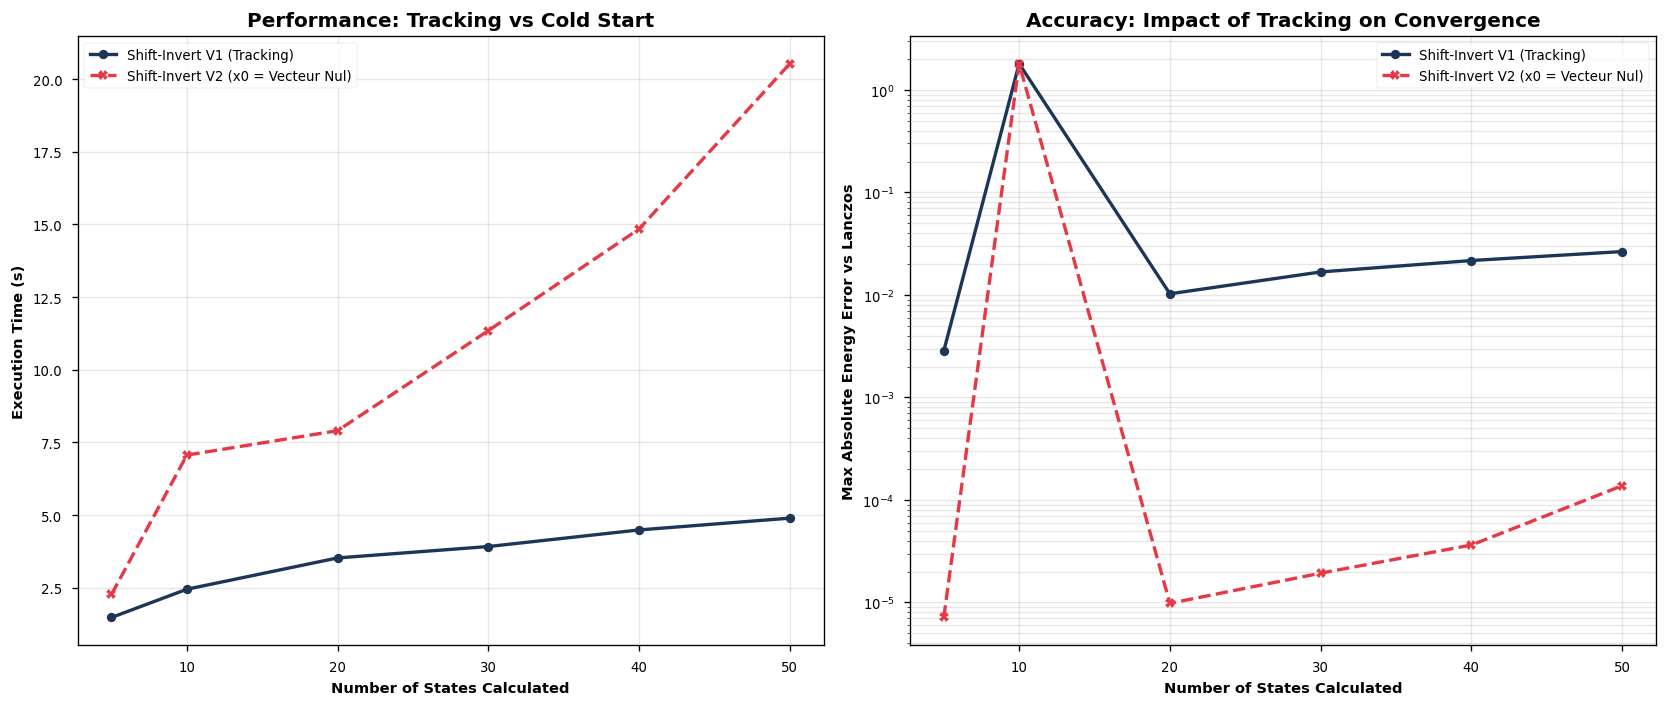

In [131]:
# --- 2. CONFIGURATION DU BENCHMARK ---
# Paramètres du système (Tes valeurs)
EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5
n_transmon_keep = 50
tol_val = 1e-8
shift_val = 1e-6

# Opérateurs
ops_data = build_naked_operators_rotated(EJ_val, EC_T_val, n_transmon_keep, n_cut=1000, osc_cut=50)
H_var_coupling_mat = lambda E_c: get_transmon_readout_matrix_explicit(ops_data, EC_R_val, EL_R_val, E_coupling=E_c)

# Paramètres de boucle
coupling_list = np.linspace(0.0, 0.03, 10, dtype=np.float64)
n_states_list = [5, 10, 20, 30, 40, 50] # On s'arrête à 50

# Stockage résultats
times_si_track = []
times_si_zero = []
errors_track = []
errors_zero = []

print("Calcul de la RÉFÉRENCE Lanczos (une seule fois)...")
E_ref_full, _ = get_values_Lanczos(H_var_coupling_mat, 50, coupling_list, tol=tol_val)

print("Démarrage du benchmark comparatif...")

# --- 3. EXÉCUTION ---
for n_st in tqdm(n_states_list, desc="Benchmark SI vs SI2"):
    
    # A. Shift-Invert VERSION 1 (Tracking)
    # ------------------------------------
    start = time.perf_counter()
    E_si_1, _ = get_values_shift_invert_real(
        H_var_coupling_mat, n_st, coupling_list, tol=tol_val, shift=shift_val
    )
    times_si_track.append(time.perf_counter() - start)
    
    # Calcul erreur vs Lanczos
    # Gestion des dimensions (Steps, Branches) ou (Branches, Steps)
    if E_si_1.shape[0] != len(coupling_list): E_si_1 = E_si_1.T
    # On compare sur les n_st premières branches
    err_1 = np.max(np.abs(E_si_1 - E_ref_full[:, :n_st]))
    errors_track.append(err_1)

    # B. Shift-Invert VERSION 2 (x0 = Vecteur Nul)
    # --------------------------------------------
    start = time.perf_counter()
    E_si_2, _ = get_values_shift_invert_real2(
        H_var_coupling_mat, n_st, coupling_list, tol=tol_val, shift=shift_val
    )
    times_si_zero.append(time.perf_counter() - start)
    
    if E_si_2.shape[0] != len(coupling_list): E_si_2 = E_si_2.T
    err_2 = np.max(np.abs(E_si_2 - E_ref_full[:, :n_st]))
    errors_zero.append(err_2)

# --- 4. TRACÉ ---
plt.style.use('seaborn-v0_8-paper')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)

# Graphique 1 : Temps de calcul
ax1.plot(n_states_list, times_si_track, label='Shift-Invert V1 (Tracking)', 
         marker='o', color='#1D3557', linestyle='-', linewidth=2)
ax1.plot(n_states_list, times_si_zero, label='Shift-Invert V2 (x0 = Vecteur Nul)', 
         marker='X', color='#E63946', linestyle='--', linewidth=2)

ax1.set_xlabel('Number of States Calculated', fontweight='bold')
ax1.set_ylabel('Execution Time (s)', fontweight='bold')
ax1.set_title('Performance: Tracking vs Cold Start', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique 2 : Erreur Max par rapport à Lanczos
ax2.plot(n_states_list, errors_track, label='Shift-Invert V1 (Tracking)', 
         marker='o', color='#1D3557', linewidth=2)
ax2.plot(n_states_list, errors_zero, label='Shift-Invert V2 (x0 = Vecteur Nul)', 
         marker='X', color='#E63946', linestyle='--', linewidth=2)

ax2.set_xlabel('Number of States Calculated', fontweight='bold')
ax2.set_ylabel('Max Absolute Energy Error vs Lanczos', fontweight='bold')
ax2.set_yscale('log') # Log scale critique ici
ax2.set_title('Accuracy: Impact of Tracking on Convergence', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

In [73]:
# The function to determine the whole branch
# param_list is the list of the different values on which we want to plot our hamiltonian


def get_branch(H_func, E_0, v_0, param_list, tol=1e-8):
    n_steps = len(param_list)
    energies = np.zeros(n_steps, dtype=np.float64)
    vectors = []

    if np.iscomplexobj(v_0):
        v_current = np.concatenate((v_0.real, v_0.imag))
        mode_2n = True
    else:
        v_current = v_0.real.astype(np.float64)
        mode_2n = False

    E_current = E_0
    energies[0] = E_current
    vectors.append(v_current)

    for i in range(1, n_steps):
        H_at_param = H_func(param_list[i])

        if mode_2n:
            H_solveur = make_real_operator_from_complex(H_at_param)
        else:
            H_solveur = H_at_param

        E_current, v_current = shift_invert_step(H_solveur, E_current, v_current, tol=tol)

        energies[i] = E_current
        vectors.append(v_current)

    return energies, np.array(vectors)

In [107]:
# This function use the other one to give all the values. It started by computing exact diagonalisation and compute
# iteratively the different branches. n_branches gives the number of eigen_value to compute.


def get_values_shift_invert_real(H_func, n_branches, param_list, shift, tol=1e-8):
    H_0 = H_func(param_list[0])
    # On s'assure de la symétrie dès le départ
    H_0 = (H_0 + H_0.T) / 2
    n_dim = H_0.shape[0]
    n_steps = len(param_list)
    
    E_initial, V_initial = sp_linalg.eigsh(H_0, k=n_branches, which="SA")
    
    all_energies = np.zeros((n_branches, n_steps), dtype=np.float64)
    all_vectors = np.zeros((n_branches, n_steps, n_dim), dtype=np.float64)
    
    current_E = E_initial.copy()
    current_V = [V_initial[:, k] for k in range(n_branches)]
    
    for k in range(n_branches):
        all_energies[k, 0] = current_E[k]
        all_vectors[k, 0, :] = current_V[k]

    for t in tqdm(range(1, n_steps)):
        H_at_param = H_func(param_list[t])
        # Symmetrization forcée à chaque pas
        #H_at_param = (H_at_param + H_at_param.T) / 2
        
        for k in range(n_branches):
            E_new, v_new = shift_invert_step(H_at_param, current_E[k], current_V[k], shift, tol=tol)
            
            current_E[k] = E_new
            current_V[k] = v_new
            
            all_energies[k, t] = E_new
            all_vectors[k, t, :] = v_new

    return all_energies, all_vectors

In [75]:
def get_values_shift_invert_complex(H_func, n_branches, param_list, tol=1e-8):
    def is_truly_complex(H_op, n_dim):
        v_test = np.random.rand(n_dim)
        try:
            res = H_op @ v_test
            return np.iscomplexobj(res) or np.issubdtype(H_op.dtype, np.complexfloating)
        except:
            return True 
        
    H_0 = H_func(param_list[0])
    n_dim = H_0.shape[0]
    
    E_initial, V_initial = sp_linalg.eigsh(H_0, k=n_branches, which="SA")
    
    n_steps = len(param_list)
    all_energies = np.zeros((n_branches, n_steps), dtype=np.float64)
    all_vectors = [[None for _ in range(n_steps)] for _ in range(n_branches)]
    
    current_E = list(E_initial)
    current_V = [V_initial[:, k] for k in range(n_branches)]
    
    is_H_complex = is_truly_complex(H_0, n_dim)
    is_V_complex = any(np.iscomplexobj(v) for v in current_V)
    
    mode_2n = is_H_complex or is_V_complex

    for k in range(n_branches):
        if mode_2n:
            current_V[k] = vec_to_real(current_V[k])
        else:
            current_V[k] = current_V[k].real.astype(np.float64)
        
        all_energies[k, 0] = current_E[k]
        all_vectors[k][0] = current_V[k]

    for t in range(1, n_steps):
        H_at_param = H_func(param_list[t])
        
        if not mode_2n:
            if is_truly_complex(H_at_param, n_dim):
                mode_2n = True
                for k in range(n_branches):
                    current_V[k] = np.concatenate((current_V[k], np.zeros_like(current_V[k])))

        if mode_2n:
            H_solveur = make_real_operator_from_complex(H_at_param)
        else:
            H_solveur = H_at_param
            
        for k in range(n_branches):
            E_new, v_new = shift_invert_step(H_solveur, current_E[k], current_V[k], tol=tol)
            
            current_E[k] = E_new
            current_V[k] = v_new
            
            all_energies[k, t] = E_new
            all_vectors[k][t] = v_new

    return all_energies, np.array(all_vectors, dtype=object)

### Lanczos targeted implementation

### Classical Lanczos implementation

In [76]:
class IterationCounter:
    def __init__(self, mat):
        self.mat = mat
        self.count = 0
    def __call__(self, x):
        self.count += 1
        return self.mat @ x


def get_values_Lanczos(H_func, n_branches, param_list, tol=1e-8):
    global residu_lanczos
    H_0 = H_func(param_list[0])
    E_initial, V_initial = sp_linalg.eigsh(H_0, k=n_branches, which="SA")
    
    idx = E_initial.argsort()
    E_initial = E_initial[idx]
    V_initial = V_initial[:, idx]

    n_steps = len(param_list)
    all_energies = np.zeros((n_steps, n_branches), dtype=np.float64)
    all_vectors = []

    all_energies[0, :] = E_initial
    all_vectors.append(V_initial)

    for i in range(1, n_steps):
        H = H_func(param_list[i])
        
        v0_guess = np.mean(all_vectors[-1], axis=1)

        H = sp_linalg.LinearOperator(H.shape, matvec=IterationCounter(H))
    
        energies_i, vectors_i = sp_linalg.eigsh(H, k=n_branches, v0=v0_guess, which="SA", tol = tol)
        
        idx = energies_i.argsort()
        energies_i = energies_i[idx]
        vectors_i = vectors_i[:, idx]

        all_energies[i, :] = energies_i
        all_vectors.append(vectors_i)

        norms = np.linalg.norm(H @ vectors_i - vectors_i * energies_i, axis=0)
        residu_lanczos.append(np.mean(norms))
    

    return all_energies, np.array(all_vectors)

## Transmon readout application

To begin, we will define the tensorial product to accelerate the computation of $H |\psi \rangle$

## 

In [77]:
def apply_tensor_product(axes: int, H: sp.spmatrix, V: np.ndarray) -> np.ndarray:
    """
    Apply sparse matrix H to the specified axis of tensor V

    Args:
        axes: which axis to apply the operator to (0, 1, 2, or 3)
        H: sparse matrix operator
        V: multi-dimensional array

    Returns:
        Result of applying H to axis 'axes' of V

    The following implementation works 3-4 times faster on smaller matrices:
    - np.einsum("ij,jabc->iabc", H, V)
    - np.dot between N-D and M-D matrices
    - reshaping and applying matrix multiplication
    However, all of them are impossible to use with sparse matrices.
    For larger matrices the implementation below for sparse matrix is faster
    by 1-1.5 times compare to implementations above on dense matrices

    """
    selected_axes_len = V.shape[axes]
    V = np.swapaxes(V, axes, 0)
    shape = V.shape
    V = np.reshape(V, (selected_axes_len, -1))
    # Apply sparse matrix multiplication
    result = H @ V
    result = np.reshape(result, shape)
    return np.swapaxes(result, 0, axes)

## Reducing the hamiltonian related to the transmon

We are aiming to compute the coupled hamiltonian for the readout transmon for higher values of the readout cutoff. To do this, we will compute the Transmon eigenvectors alone, then inject them in the coupled hamiltonian.

We are starting from this hamiltonian : 
$$\hat{H} = \left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] \otimes \mathbb{I} 
+ \mathbb{I} \otimes \left( \hbar\omega(\hat{a}^\dagger\hat{a}) + \frac{1}{2} \right)
- 4E_{coupling} \hat{n}_T \otimes \left(i n_{ZPF}(\hat{a}^\dagger - \hat{a}) \right)$$

Studying $\left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right]$ in the charge basis gives us the decomposition in the diagonale basis, $$\left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] = \sum^{2*cutoff+1}_{i=0} \lambda_i |\psi_i \rangle \langle \psi_i| \quad \text{with} \quad |\lambda_i \rangle = \sum_{j=-cutoff}^{cutoff} c_{ij} | i \rangle$$

We will select the 4 lowest energies and extract a 4*4 matrix with them. Same for $\hat{n_t}$ that we will project on this 4 vector space.We will 

Then, we are able to build the whole operator which depends on the physical constants.

In [78]:
def reduce_transmon_operators(Op_charge_T, Op_tunnel_T, Op_n_T, EJ, EC_T, n_transmon_keep):
    """
    Construit l'Hamiltonien transmon dans la base de charge complète,
    diagonalise pour trouver les n_transmon_keep premiers états,
    et projette H et n_T dans ce sous-espace.
    """

    H_T_full = 4.0 * EC_T * Op_charge_T - 0.5 * EJ * Op_tunnel_T

    evals, evecs = sp_linalg.eigsh(H_T_full, k=n_transmon_keep, which="SA")

    sort_indices = np.argsort(evals)
    evals = evals[sort_indices]
    evecs = evecs[:, sort_indices]

    H_T_reduced = sp.diags(evals, format="csr")

    n_T_projected = evecs.conj().T @ (Op_n_T @ evecs)

    n_T_reduced = sp.csr_matrix(n_T_projected)

    return H_T_reduced, n_T_reduced

We use this function to build only one time the big matrixes that cost a lot in memory

In [79]:
def build_naked_operators(EJ, EC_T, n_transmon_keep=10, n_cut=100, osc_cut=10):
    dim_T = 2 * n_cut + 1

    n_values = np.arange(-n_cut, n_cut + 1)
    Op_charge_T = sp.diags(n_values**2, format="csr")  # Juste n^2

    Op_n_T = sp.diags(n_values, format="csr")

    ones = np.ones(dim_T - 1)
    Op_tunnel_T = sp.diags([ones, ones], offsets=[-1, 1], format="csr")

    H_T_reduced, Op_n_T_reduced = reduce_transmon_operators(Op_charge_T, Op_tunnel_T, Op_n_T, EJ, EC_T, n_transmon_keep)
    dim_T = n_transmon_keep

    dim_R = osc_cut
    sqrt_vals = np.sqrt(np.arange(1, osc_cut))
    a = sp.diags(sqrt_vals, offsets=1, format="csr")
    a_dag = a.H

    Op_number_R = a_dag @ a

    Op_disp_R = 1j * (a_dag - a)

    dims = (dim_T, dim_R)

    return dims, H_T_reduced, Op_n_T_reduced, Op_number_R, Op_disp_R


def build_naked_operators_rotated(EJ, EC_T, n_transmon_keep=10, n_cut=100, osc_cut=10):
    dim_T = 2 * n_cut + 1

    n_values = np.arange(-n_cut, n_cut + 1)
    Op_charge_T = sp.diags(n_values**2, format="csr")  # Juste n^2

    Op_n_T = sp.diags(n_values, format="csr")

    ones = np.ones(dim_T - 1)
    Op_tunnel_T = sp.diags([ones, ones], offsets=[-1, 1], format="csr")

    H_T_reduced, Op_n_T_reduced = reduce_transmon_operators(Op_charge_T, Op_tunnel_T, Op_n_T, EJ, EC_T, n_transmon_keep)
    dim_T = n_transmon_keep

    dim_R = osc_cut
    sqrt_vals = np.sqrt(np.arange(1, osc_cut))
    b = sp.diags(sqrt_vals, offsets=1, format="csr")
    b_dag = (b.conj().T).tocsr()

    Op_number_R = b_dag @ b

    Op_disp_R = -(b_dag + b)

    dims = (dim_T, dim_R)

    return dims, H_T_reduced, Op_n_T_reduced, Op_number_R, Op_disp_R

In [80]:
def get_transmon_readout_hamiltonian(ops_bundle, EC_R, EL_R, E_coupling):
    dims, H_T_reduced, Op_n_T_reduced, Op_num_R, Op_disp_R = ops_bundle
    total_dim = dims[0] * dims[1]

    omega = np.sqrt(8 * EL_R * EC_R)
    n_zpf = (EL_R / (32 * EC_R)) ** 0.25

    all_ops = [H_T_reduced, Op_n_T_reduced, Op_num_R, Op_disp_R]
    all_dtypes = [op.dtype for op in all_ops]
    determine_dtype = np.result_type(*all_dtypes)

    def matvec_action(v_flat):
        V = v_flat.reshape(dims).astype(determine_dtype, copy=False)

        psi_transmon = apply_tensor_product(0, H_T_reduced, V)

        psi_res = apply_tensor_product(1, Op_num_R, V)
        psi_res *= omega
        psi_res += (0.5 * omega) * V

        temp = apply_tensor_product(1, Op_disp_R, V)
        psi_int = apply_tensor_product(0, Op_n_T_reduced, temp)
        psi_int *= -4 * E_coupling * n_zpf

        return (psi_transmon + psi_res + psi_int).ravel()

    return sp_linalg.LinearOperator(
        (total_dim, total_dim), 
        matvec=matvec_action, 
        dtype=determine_dtype
    )

### The version without the tensor product and a full matrix

In [81]:
def get_transmon_readout_matrix_explicit(ops_bundle, EC_R, EL_R, E_coupling):
    dims, H_T_reduced, Op_n_T_reduced, Op_num_R, Op_disp_R = ops_bundle

    omega = np.sqrt(8 * EL_R * EC_R)
    n_zpf = (EL_R / (32 * EC_R)) ** 0.25

    I_T = sp.eye(dims[0], format="csr", dtype=np.float64)
    I_R = sp.eye(dims[1], format="csr", dtype=np.float64)

    H_T_local = H_T_reduced
    H_T_full = sp.kron(H_T_local, I_R, format="csr")

    H_R_local = omega * (Op_num_R + 0.5 * sp.eye(dims[1], dtype=np.float64))
    H_R_full = sp.kron(I_T, H_R_local, format="csr")

    term_R_int = n_zpf * Op_disp_R
    H_int_full = sp.kron(Op_n_T_reduced, term_R_int, format="csr")
    H_int_full *= -4 * E_coupling

    H_total = H_T_full + H_R_full + H_int_full

    return H_total

Lets test our code, we will choose $E_c$ as the varying parameter

In [108]:
EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5
n_transmon_keep = 30
n_branches = 40
i=0
time_min_res = 0
shift = 0
residu_shift = []
residu_lanczos = []
iterations = []
ncv = []
niter = []

ops_data = build_naked_operators_rotated(EJ_val, EC_T_val, n_transmon_keep, n_cut=300, osc_cut=40)

H_var_coupling_mat = lambda E_coupling: get_transmon_readout_matrix_explicit(  # noqa: E731
    ops_data, EC_R_val, EL_R_val, E_coupling=E_coupling
)

coupling_list = np.linspace(0, 0.2, 25, dtype=np.float64)

start_l = time.perf_counter()
energies_l, vectors_l = get_values_Lanczos(H_var_coupling_mat, n_branches, param_list=coupling_list,tol = 1e-5)
end_l = time.perf_counter()

print(f"Lanczos a pris {end_l - start_l} secondes")

start_si = time.perf_counter()
energies_si, vectors_si = get_values_shift_invert_real(H_var_coupling_mat, n_branches,param_list=coupling_list, shift = shift, tol=1e-5)
end_si = time.perf_counter()

print(f"Shift invert a pris {end_si - start_si} secondes")
print(f'Le temps pris par minres est {time_min_res}')
print(f'Le residu de shift invert vaut en moyenne {np.mean(residu_shift)}')
print(f'Le residu de Lanczos vaut en moyenne {np.mean(residu_lanczos)}')



Lanczos a pris 5.793852800037712 secondes


  0%|          | 0/24 [00:00<?, ?it/s]

Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time


In [87]:
import matplotlib.pyplot as plt

EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5
n_transmon_keep = 30
n_branches = 30
i=0
time_min_res = 0
shift = 10
residu_shift = []
residu_lanczos = []
iterations = []
ncv = []
niter = []

ops_data = build_naked_operators_rotated(EJ_val, EC_T_val, n_transmon_keep, n_cut=300, osc_cut=30)

H_var_coupling_mat = lambda E_coupling: get_transmon_readout_matrix_explicit(  # noqa: E731
    ops_data, EC_R_val, EL_R_val, E_coupling=E_coupling
)

coupling_list = np.linspace(0.1, 0.2, 10, dtype=np.float64)

# 1. LANCZOS (Référence Absolue)
print("Calcul de référence (Lanczos)...")
start_l = time.perf_counter()
energies_ref, vectors_ref = get_values_Lanczos(H_var_coupling_mat, n_branches, param_list=coupling_list, tol=1e-8)
end_l = time.perf_counter()
time_lanczos = end_l - start_l
print(f"Lanczos terminé en {time_lanczos:.4f} s")

# 2. BENCHMARK SHIFT
offsets = [0.0, 1e-14, 1e-11, 1e-8, 1e-5, 1e-3, 1e-2, 0.1, 0.5]
results_time = []
results_error_max = []
results_error_avg = []
results_iter_avg = []

print("\nDébut du benchmark Shift-Invert...")

for offset in offsets:
    # Reset des globales pour être propre
    iterations = [] 
    residu_shift = []
    time_min_res = 0
    
    # Appel de ta fonction (modifiée pour accepter shift_offset)
    start_si = time.perf_counter()
    E_si, V_si = get_values_shift_invert_real(
        H_var_coupling_mat, 
        n_branches, 
        param_list=coupling_list, 
        tol=1e-8,
        shift=offset # <--- Nouveau paramètre
    )
    end_si = time.perf_counter()
    
    total_time = end_si - start_si
    
    # --- METRIQUES ---
    
    # 1. Erreur sur l'énergie par rapport à Lanczos
    # On prend la valeur absolue de la différence
    diff = np.abs(E_si.T - energies_ref)
    max_err = np.max(diff) # Le pire cas (souvent aux croisements)
    avg_err = np.mean(diff) # L'erreur moyenne
    
    # 2. Nombre moyen d'itérations minres
    avg_iter = np.mean(iterations) if iterations else 0
    
    print(f"Offset {offset:.1e} : Temps = {total_time:.2f}s | Max Err = {max_err:.2e} | Iter moy = {avg_iter:.1f}")
    
    results_time.append(total_time)
    results_error_max.append(max_err)
    results_iter_avg.append(avg_iter)

# --- PLOTS ---

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Shift Offset (Log Scale)')
ax1.set_ylabel('Temps de Calcul (s)', color=color)
ax1.plot(offsets, results_time, marker='o', color=color, label='Temps Shift-Invert')
ax1.axhline(y=time_lanczos, color='green', linestyle='--', label='Temps Lanczos (Ref)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('symlog', linthresh=1e-12) # Echelle log qui gère le 0

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Max Energy Error', color=color)  
ax2.plot(offsets, results_error_max, marker='s', linestyle='--', color=color, label='Erreur Max')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

plt.title("Benchmark : Impact de l'offset sur Shift-Invert")
fig.tight_layout()  
plt.show()

Calcul de référence (Lanczos)...
Lanczos terminé en 1.4935 s

Début du benchmark Shift-Invert...


KeyboardInterrupt: 

Démarrage du benchmark sur 10 points de couplage...


Progression du benchmark:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

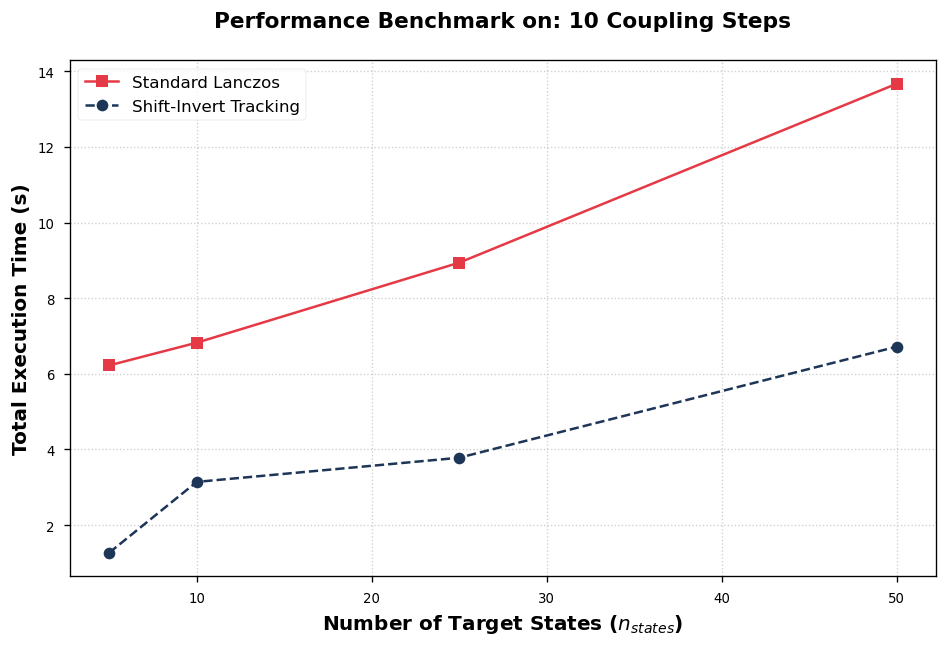

In [133]:
EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5
n_transmon_keep = 50
tol_val = 1e-8
shift_val = 1e-6

ops_data = build_naked_operators_rotated(EJ_val, EC_T_val, n_transmon_keep, n_cut=1000, osc_cut=50)

H_var_coupling_mat = lambda E_coupling: get_transmon_readout_matrix_explicit(  # noqa: E731
    ops_data, EC_R_val, EL_R_val, E_coupling=E_coupling
)

# Liste des points de couplage (10 points comme demandé)
coupling_list = np.linspace(0.0, 0.03, 10, dtype=np.float64)

# Liste des n_branches à tester
n_states_list = [5, 10, 25, 50, 75, 100, 200]
n_states_list = [5, 10, 25, 50]

times_lanczos = []
times_si = []

print(f"Démarrage du benchmark sur {len(coupling_list)} points de couplage...")

# Utilisation de tqdm pour suivre l'avancement du benchmark
for n_st in tqdm(n_states_list, desc="Progression du benchmark"):
    
    # 1. Benchmark LANCZOS (Séquence complète de 10 points)
    start_l = time.perf_counter()
    _, _ = get_values_Lanczos(
        H_var_coupling_mat, 
        n_st, 
        param_list=coupling_list, 
        tol=tol_val
    )
    times_lanczos.append(time.perf_counter() - start_l)
    
    # 2. Benchmark SHIFT-INVERT (Séquence complète de 10 points)
    start_si = time.perf_counter()
    _, _ = get_values_shift_invert_real(
        H_var_coupling_mat, 
        n_st, 
        param_list=coupling_list, 
        tol=tol_val,
        shift=shift_val
    )
    times_si.append(time.perf_counter() - start_si)

# --- TRACÉ STYLE ARTICLE DE RECHERCHE ---
plt.style.use('seaborn-v0_8-paper') # Style académique propre
fig, ax = plt.subplots(figsize=(8, 5.5), dpi=120)

# Courbe Lanczos
ax.plot(n_states_list, times_lanczos, 
        label='Standard Lanczos', 
        color='#E63946', 
        marker='s', markersize=7, linewidth=1.5, linestyle='-')

# Courbe Shift-Invert
ax.plot(n_states_list, times_si, 
        label='Shift-Invert Tracking', 
        color='#1D3557', 
        marker='o', markersize=7, linewidth=1.5, linestyle='--')

# Configuration scientifique des axes
ax.set_xlabel(r'Number of Target States ($n_{states}$)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Execution Time (s)', fontsize=12, fontweight='bold')
ax.set_title(f'Performance Benchmark on: {len(coupling_list)} Coupling Steps', 
             fontsize=13, pad=20, fontweight='bold')

# Ajout d'une grille légère
ax.grid(True, which='both', linestyle=':', alpha=0.6)

# Légende élégante
ax.legend(loc='upper left', frameon=True, shadow=False, fontsize=10)

# Optimisation des marges
plt.tight_layout()

# Affichage
plt.show()

Calcul des énergies de référence (Lanczos)...
Calcul des énergies test (Shift-Invert)...


  0%|          | 0/29 [00:00<?, ?it/s]

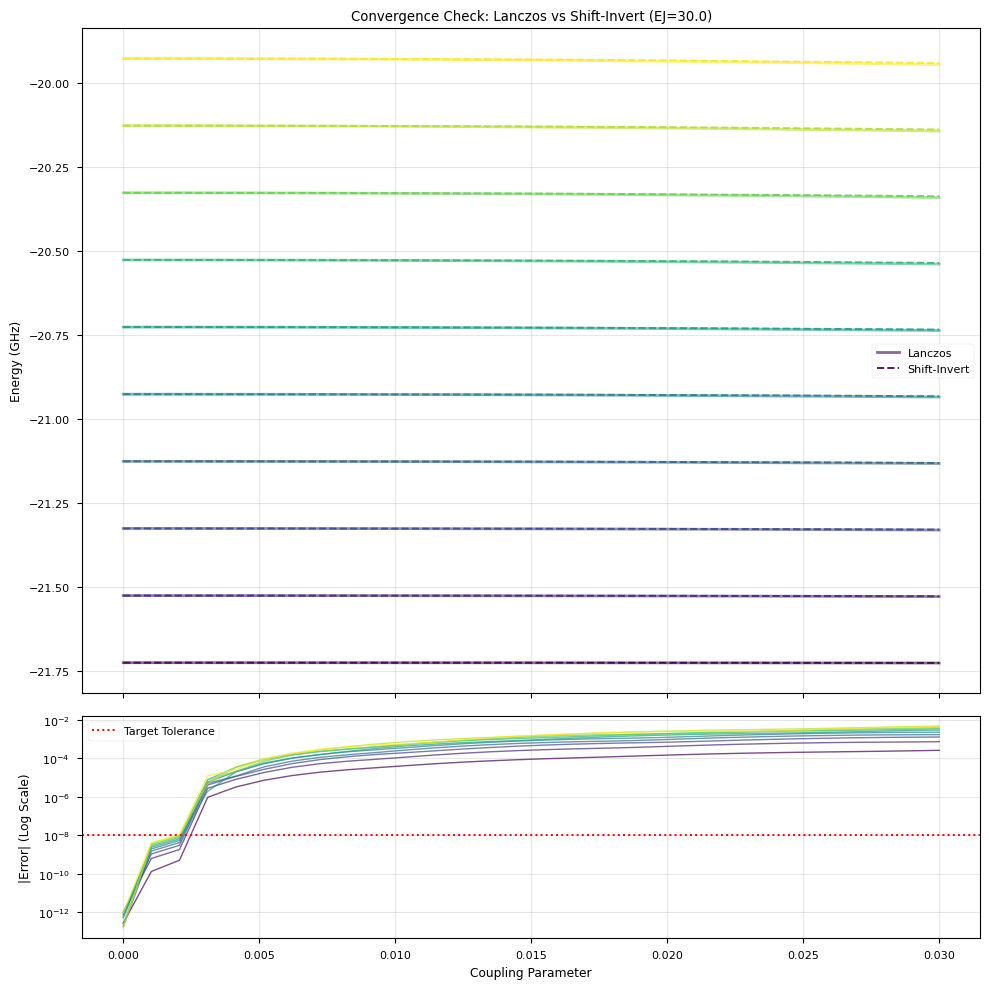

In [134]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp

# --- 1. PARAMÈTRES (Tes valeurs) ---
EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5
n_transmon_keep = 50

# Paramètres de simulation
n_states_plot = 10       # On regarde les 10 premiers niveaux pour y voir clair
coupling_plot = np.linspace(0.0, 0.03, 30) # 30 points pour avoir de jolies courbes

# --- 2. CONSTRUCTION DES OPÉRATEURS ---
# (Assure-toi que build_naked_operators_rotated et get_transmon_readout_matrix_explicit sont définies)
ops_data = build_naked_operators_rotated(EJ_val, EC_T_val, n_transmon_keep, n_cut=1000, osc_cut=50)

H_func = lambda E_c: get_transmon_readout_matrix_explicit(
    ops_data, EC_R_val, EL_R_val, E_coupling=E_c
)

print("Calcul des énergies de référence (Lanczos)...")
E_lanczos, _ = get_values_Lanczos(
    H_func, n_states_plot, param_list=coupling_plot, tol=1e-8
)

print("Calcul des énergies test (Shift-Invert)...")
# Utilise bien ta fonction shift-invert actuelle (robust ou real)
E_si, _ = get_values_shift_invert_real(
    H_func, n_states_plot, param_list=coupling_plot, tol=1e-8, shift=1e-6
)

# --- 3. TRACÉ DES COURBES ET DE L'ERREUR ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# --- Plot A : Les Énergies ---
colors = plt.cm.viridis(np.linspace(0, 1, n_states_plot))

for k in range(n_states_plot):
    # Ligne continue pour Lanczos
    ax1.plot(coupling_plot, E_lanczos[:, k], color=colors[k], linewidth=2, alpha=0.6, label="Lanczos" if k==0 else "")
    
    # Croix ou pointillés pour Shift-Invert
    # Attention aux dimensions : E_si peut être (n_branches, n_steps) ou l'inverse selon ta fonction
    if E_si.shape[0] != len(coupling_plot):
        val_si = E_si[k, :] # Si forme (branches, steps)
    else:
        val_si = E_si[:, k] # Si forme (steps, branches)
        
    ax1.plot(coupling_plot, val_si, color=colors[k], linestyle='--', marker='x', markersize=4, alpha=0.9, label="Shift-Invert" if k==0 else "")

ax1.set_ylabel("Energy (GHz)")
ax1.set_title(f"Convergence Check: Lanczos vs Shift-Invert (EJ={EJ_val})")
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Plot B : L'Erreur Absolue ---
ax2.set_ylabel("|Error| (Log Scale)")
ax2.set_xlabel("Coupling Parameter")
ax2.set_yscale('log')

for k in range(n_states_plot):
    if E_si.shape[0] != len(coupling_plot):
        diff = np.abs(E_lanczos[:, k] - E_si[k, :])
    else:
        diff = np.abs(E_lanczos[:, k] - E_si[:, k])
        
    ax2.plot(coupling_plot, diff, color=colors[k], linewidth=1, alpha=0.7)

# Ligne de référence à 1e-8 (ta tolérance)
ax2.axhline(1e-8, color='red', linestyle=':', label='Target Tolerance')
ax2.legend()
ax2.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

Démarrage du benchmark LANCZOS sur 10 configurations...
Dimension totale de l'espace de Hilbert : 2500


Progression Lanczos:   0%|          | 0/10 [00:00<?, ?it/s]

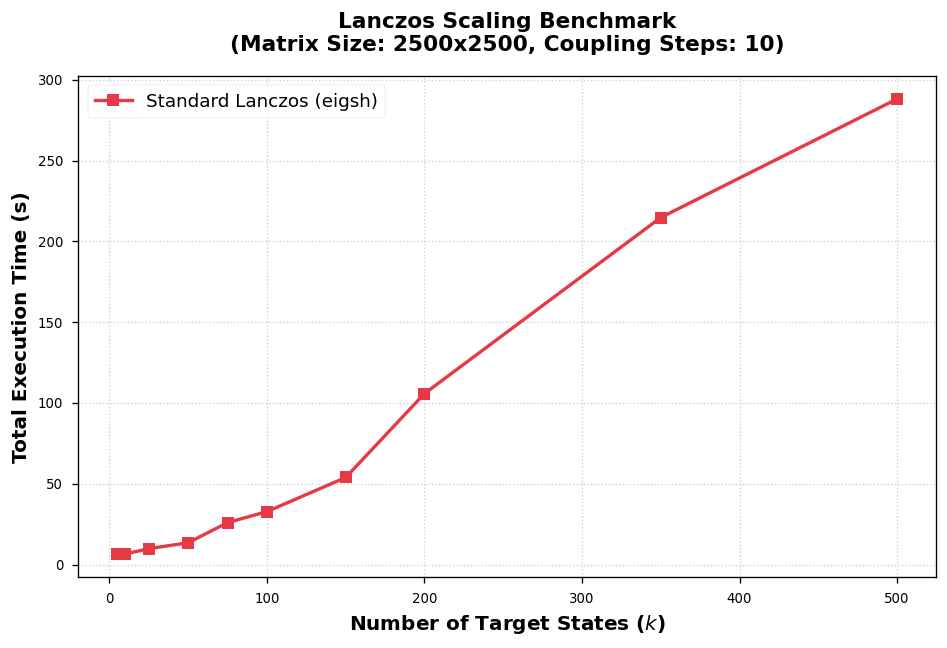

In [118]:
ops_data = build_naked_operators_rotated(EJ_val, EC_T_val, n_transmon_keep, n_cut=1000, osc_cut=50)

H_var_coupling_mat = lambda E_coupling: get_transmon_readout_matrix_explicit(  # noqa: E731
    ops_data, EC_R_val, EL_R_val, E_coupling=E_coupling
)

# Liste des points de couplage (10 points)
coupling_list = np.linspace(0.0, 0.03, 10, dtype=np.float64)

# Liste mise à jour avec tes nouvelles valeurs
n_states_list = [5, 10, 25, 50, 75, 100, 150, 200, 350, 500]

times_lanczos = []

print(f"Démarrage du benchmark LANCZOS sur {len(n_states_list)} configurations...")
print(f"Dimension totale de l'espace de Hilbert : {n_transmon_keep * 50}")

# --- 2. BOUCLE DE BENCHMARK ---
for n_st in tqdm(n_states_list, desc="Progression Lanczos"):
    
    # On mesure le temps pour calculer TOUTE la séquence de couplage
    start_l = time.perf_counter()
    _, _ = get_values_Lanczos(
        H_var_coupling_mat, 
        n_st, 
        param_list=coupling_list, 
        tol=tol_val
    )
    times_lanczos.append(time.perf_counter() - start_l)

# --- 3. TRACÉ ---
plt.style.use('seaborn-v0_8-paper')
fig, ax = plt.subplots(figsize=(8, 5.5), dpi=120)

# Courbe Lanczos Seule
ax.plot(n_states_list, times_lanczos, 
        label='Standard Lanczos (eigsh)', 
        color='#E63946', 
        marker='s', markersize=7, linewidth=2, linestyle='-')

# Configuration des axes
ax.set_xlabel(r'Number of Target States ($k$)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Execution Time (s)', fontsize=12, fontweight='bold')
ax.set_title(f'Lanczos Scaling Benchmark\n(Matrix Size: {n_transmon_keep*50}x{n_transmon_keep*50}, Coupling Steps: {len(coupling_list)})', 
             fontsize=13, pad=15, fontweight='bold')

# Grille et Légende
ax.grid(True, which='both', linestyle=':', alpha=0.6)
ax.legend(loc='upper left', frameon=True, shadow=False, fontsize=11)

plt.tight_layout()
plt.show()

Transposition de energies_si : (30, 50) -> (50, 30)


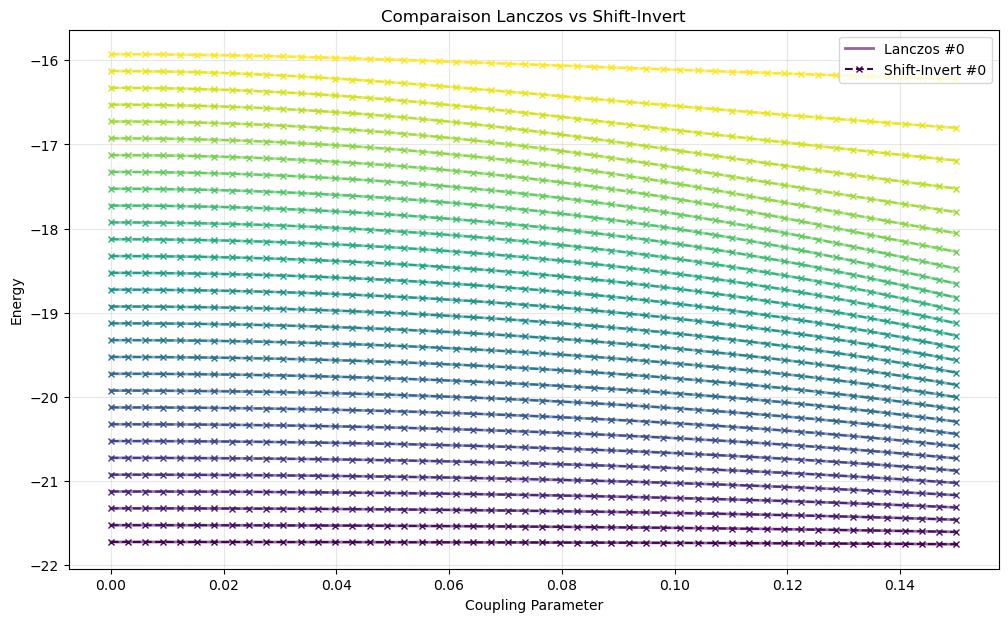

In [85]:
def plot_comparison(energies_ref, energies_test, param_list, title="Comparaison Lanczos vs Shift-Invert"):
    # 1. GESTION DES DIMENSIONS
    # On veut que tout soit sous la forme (n_steps, n_branches)
    
    # Si Shift-Invert est (n_branches, n_steps), on transpose
    if energies_test.shape[0] != len(param_list):
        print(f"Transposition de energies_si : {energies_test.shape} -> {energies_test.T.shape}")
        energies_test = energies_test.T
        
    # Idem pour Lanczos par sécurité
    if energies_ref.shape[0] != len(param_list):
        energies_ref = energies_ref.T

    n_branches = energies_ref.shape[1]
    n_steps = energies_ref.shape[0]

    # 2. TRACÉ
    fig, ax = plt.subplots(figsize=(12, 7))

    # On ne trace que les 10 premières branches pour y voir clair (ou n_branches si < 10)
    k_max = min(n_branches, 30) 
    
    # Palette de couleurs
    colors = plt.cm.viridis(np.linspace(0, 1, k_max))

    for k in range(k_max):
        # A. LANCZOS (Ligne continue solide)
        # C'est la "Vérité Terrain" triée (E0 < E1 < E2...)
        ax.plot(param_list, energies_ref[:, k], color=colors[k], linestyle='-', linewidth=2, alpha=0.6, label=f'Lanczos #{k}' if k==0 else "")
        
        # B. SHIFT-INVERT (Pointillés ou Croix)
        # C'est ton algo de tracking
        ax.plot(param_list, energies_test[:, k], color=colors[k], linestyle='--', marker='x', markersize=5, label=f'Shift-Invert #{k}' if k==0 else "")

    ax.set_xlabel('Coupling Parameter')
    ax.set_ylabel('Energy')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.show()

# --- EXÉCUTION ---
# Remplace 'E_si' par le nom de ta variable contenant les résultats du dernier shift testé
# Si ton dernier résultat s'appelait E_si dans la boucle :
plot_comparison(energies_l, E_si, coupling_list)

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Vérification des dimensions pour le plot
# Matplotlib aime avoir (n_steps, n_branches) pour tracer les colonnes.
# Si tes données sont (3, 80), on transpose pour avoir (80, 3).
if energies_l.shape[0] != len(coupling_list):
    energies_l = energies_l.T
if energies_si.shape[0] != len(coupling_list):
    energies_si = energies_si.T

# 2. Calcul de la différence (Erreur absolue)
diff = np.abs(energies_l - energies_si)

# 3. Création des 3 graphiques
fig, axs = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

# --- Plot 1 : Lanczos (Référence) ---
axs[0].plot(coupling_list, energies_l, linewidth=2.5, alpha=0.9)
axs[0].set_ylabel("Énergie ($E_J$)", fontsize=12)
axs[0].set_title("Méthode 1 : Lanczos / eigsh (Référence)", fontsize=14, fontweight="bold")
axs[0].grid(True, which="both", linestyle="--", alpha=0.6)
axs[0].legend([f"Branche {i}" for i in range(energies_l.shape[1])], loc="upper right")

# --- Plot 2 : Shift-Invert (Ton Algo) ---
# J'utilise des tirets (--) pour bien distinguer visuellement du trait plein
axs[1].plot(coupling_list, energies_si, linewidth=2, linestyle="--")
axs[1].set_ylabel("Énergie ($E_J$)", fontsize=12)
axs[1].set_title("Méthode 2 : Shift-Invert", fontsize=14, fontweight="bold")
axs[1].grid(True, which="both", linestyle="--", alpha=0.6)

# --- Plot 3 : Différence (Échelle Logarithmique) ---
# C'est ici qu'on juge la qualité de la convergence
for i in range(diff.shape[1]):
    axs[2].semilogy(coupling_list, diff[:, i], label=f"Erreur Branche {i}", linewidth=1.5)

axs[2].set_ylabel("Erreur Absolue ($|E_L - E_{SI}|$)", fontsize=12)
axs[2].set_xlabel("Couplage ($E_{coupling}$)", fontsize=12)
axs[2].set_title("Différence entre les deux méthodes", fontsize=14, fontweight="bold")
axs[2].grid(True, which="both", linestyle="--", alpha=0.6)
axs[2].legend()

# Mise en page
plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (50,30) (25,40) 

### On complex hamiltonians

In [123]:
EJ_val = 30.0
EC_T_val = 1.2
EC_R_val = 0.01
EL_R_val = 0.5
n_transmon_keep = 25
osc_cut = 50

ops_data_complex = build_naked_operators(EJ_val, EC_T_val, n_transmon_keep, n_cut=300, osc_cut=osc_cut)

H_var_coupling = lambda E_coupling: get_transmon_readout_hamiltonian(  # noqa: E731
    ops_data_complex, EC_R_val, EL_R_val, E_coupling=E_coupling
)

H_var_coupling_mat = lambda E_coupling: get_transmon_readout_matrix_explicit(  # noqa: E731
    ops_data_complex, EC_R_val, EL_R_val, E_coupling=E_coupling
)


coupling_list = np.linspace(0.0, 0.6, 80, dtype=np.float64)

start_si_opt_c = time.perf_counter()
energies_si_opt_c, vectors_si_opt_c = get_values_shift_invert_complex(H_var_coupling, n_branches=3, param_list=coupling_list,)
end_si_opt_c = time.perf_counter()

start_l_c = time.perf_counter()
energies_l_c, vectors_l_c = get_values_Lanczos(H_var_coupling, n_branches=3, param_list=coupling_list)
end_l_c = time.perf_counter()

start_mat_c = time.perf_counter()
energies_mat_c, vectors_mat_c = get_values_Lanczos(H_var_coupling_mat, n_branches=3, param_list=coupling_list)
end_mat_c = time.perf_counter()

print(f"Lanczos matriciel a pris {end_mat_c - start_mat_c} secondes")
print(f"Lanczos a pris {end_l_c - start_l_c} secondes")
print(f"Shift invert a pris {end_si_opt_c - start_si_opt_c} secondes")


Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time
Did not converge in time


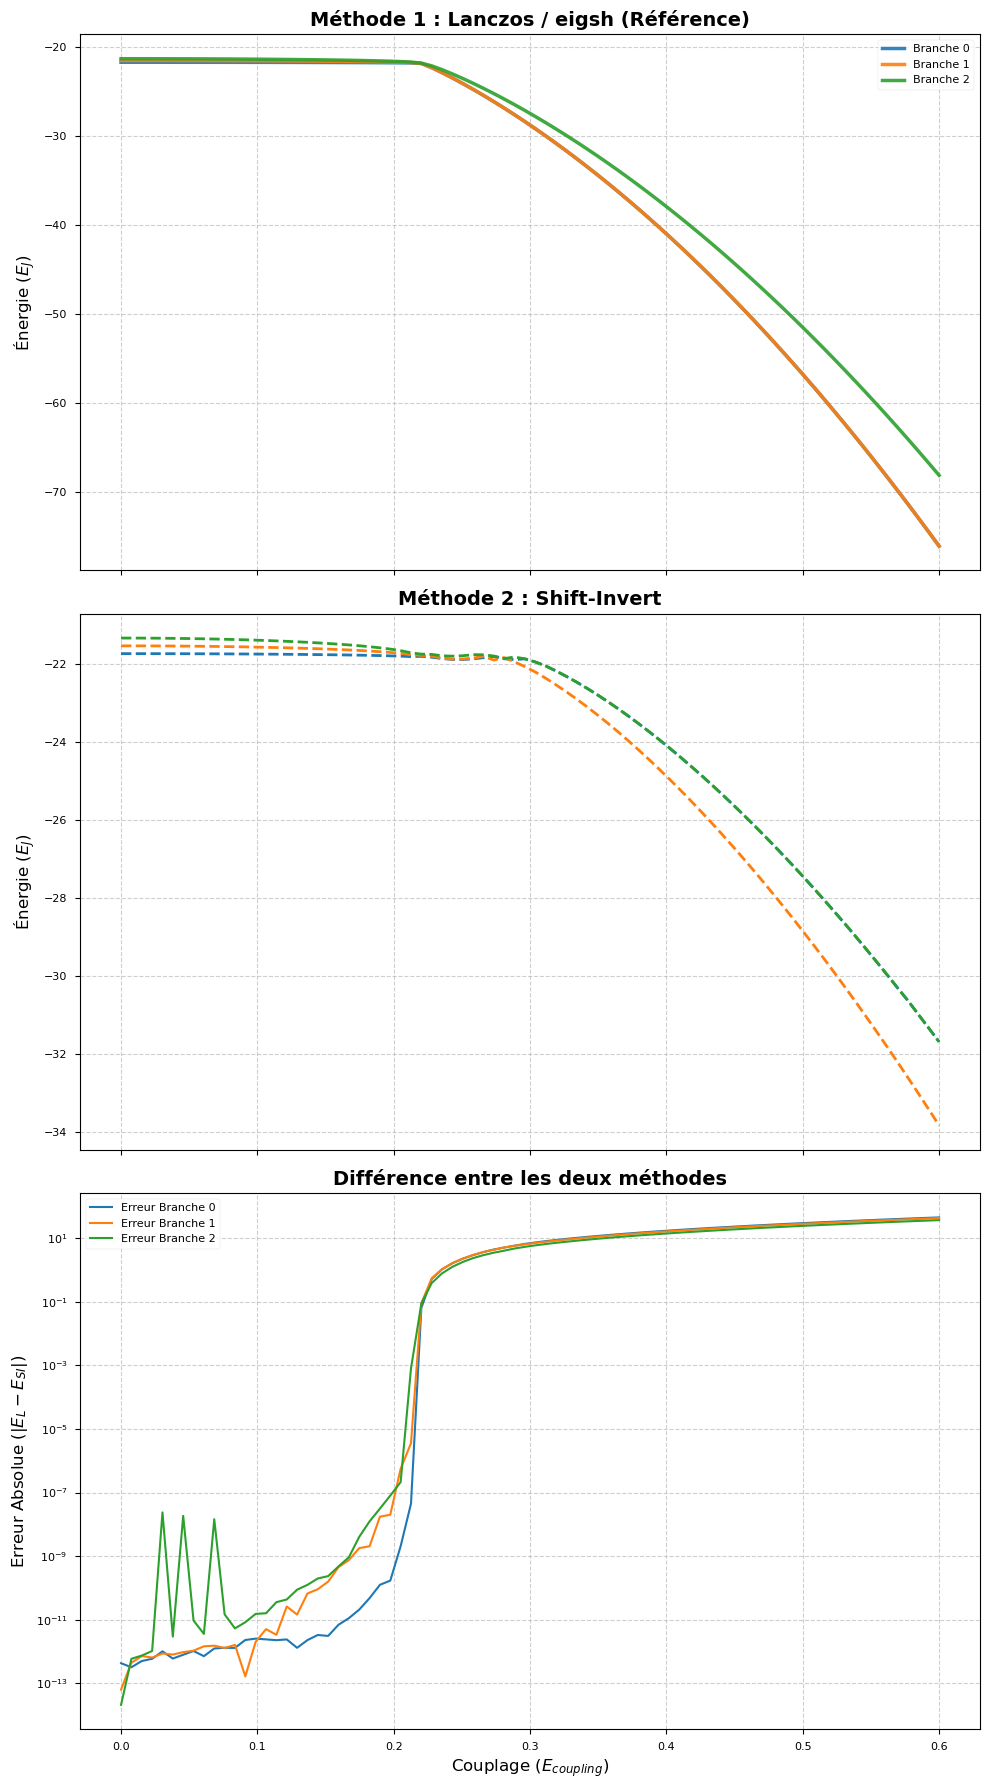

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Vérification des dimensions pour le plot
# Matplotlib aime avoir (n_steps, n_branches) pour tracer les colonnes.
# Si tes données sont (3, 80), on transpose pour avoir (80, 3).
if energies_l_c.shape[0] != len(coupling_list):
    energies_l_c = energies_l_c.T
if energies_si_opt_c.shape[0] != len(coupling_list):
    energies_si_opt_c = energies_si_opt_c.T

# 2. Calcul de la différence (Erreur absolue)
diff = np.abs(energies_l_c - energies_si_opt_c)

# 3. Création des 3 graphiques
fig, axs = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

# --- Plot 1 : Lanczos (Référence) ---
axs[0].plot(coupling_list, energies_l_c, linewidth=2.5, alpha=0.9)
axs[0].set_ylabel("Énergie ($E_J$)", fontsize=12)
axs[0].set_title("Méthode 1 : Lanczos / eigsh (Référence)", fontsize=14, fontweight="bold")
axs[0].grid(True, which="both", linestyle="--", alpha=0.6)
axs[0].legend([f"Branche {i}" for i in range(energies_l_c.shape[1])], loc="upper right")

# --- Plot 2 : Shift-Invert (Ton Algo) ---
# J'utilise des tirets (--) pour bien distinguer visuellement du trait plein
axs[1].plot(coupling_list, energies_si_opt_c, linewidth=2, linestyle="--")
axs[1].set_ylabel("Énergie ($E_J$)", fontsize=12)
axs[1].set_title("Méthode 2 : Shift-Invert", fontsize=14, fontweight="bold")
axs[1].grid(True, which="both", linestyle="--", alpha=0.6)

# --- Plot 3 : Différence (Échelle Logarithmique) ---
# C'est ici qu'on juge la qualité de la convergence
for i in range(diff.shape[1]):
    axs[2].semilogy(coupling_list, diff[:, i], label=f"Erreur Branche {i}", linewidth=1.5)

axs[2].set_ylabel("Erreur Absolue ($|E_L - E_{SI}|$)", fontsize=12)
axs[2].set_xlabel("Couplage ($E_{coupling}$)", fontsize=12)
axs[2].set_title("Différence entre les deux méthodes", fontsize=14, fontweight="bold")
axs[2].grid(True, which="both", linestyle="--", alpha=0.6)
axs[2].legend()

# Mise en page
plt.tight_layout()
plt.show()